In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
!ls "/content/drive/My Drive/diploma/"

datasets  diploma.ipynb  LICENSE  README.md  requirements.txt  trained_models


In [0]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader 
import torchvision
from torchvision import transforms, utils

In [4]:
print("Torch version: {}".format(torch.__version__))
print("Torchvision version: {}".format(torchvision.__version__))

Torch version: 1.0.1.post2
Torchvision version: 0.2.2


In [5]:
torch.cuda.is_available()

True

In [0]:
path_to_app = "/content/drive/My Drive/diploma/"

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
}

trainset = torchvision.datasets.CIFAR10(root=os.path.join(path_to_app, "datasets"), train=True,
                                        transform=data_transforms['train'], download=True)
trainset_loader = DataLoader(trainset, batch_size=10, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=os.path.join(path_to_app, "datasets"), train=False,
                                      transform=data_transforms['test'], download=True)
testset_loader = DataLoader(testset, batch_size=10, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def imshow(images):
    images = images / 2 + 0.5
    np_img = images.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

In [0]:
dataiter = iter(trainset_loader)
images, labels = dataiter.next()

In [10]:
print('Images shape {}'.format(images.size()))
print('Labels shape {}'.format(labels.shape))

Images shape torch.Size([10, 3, 32, 32])
Labels shape torch.Size([10])


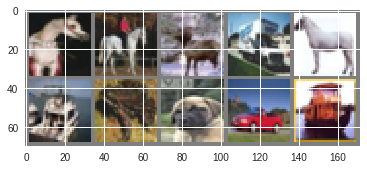

horse horse deer truck horse ship frog dog car ship


In [11]:
# Show 10 images
imshow(utils.make_grid(images, nrow=5))
print(' '.join('%s' % classes[labels[j]] for j in range(len(labels))))

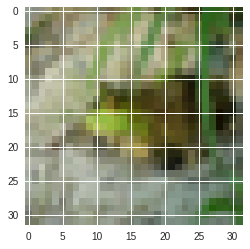

frog


In [12]:
# Show 1 image
images, labels = dataiter.next()
imshow(images[0])
print(classes[labels[0]])

In [0]:
import torch.nn as nn

In [0]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            # Input: (32x32x3)
            # Output (32x32x32)
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # Output: (32x32x64)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # Output: (16x16x64)
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer block2
            
            # Output: (16x16x128)
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # Output: (16x16x128)
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # Output: (8x8x128)
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer block2
            
            # Output: (8x8x256)
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # Output: (8x8x256)
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # Output: (4x4x256)
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layer = nn.Sequential(
            # 4096 = 4*4*256
            nn.Linear(in_features=4096, out_features=1024),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512, out_features=10)
        )
        
    def forward(self, x):
        
        x = self.conv_layer(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        x = self.fc_layer(x)
        
        return x

In [0]:
import time

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time() 
    
    train_acc_history = []
    val_acc_history = []
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}:\n".format(epoch+1, num_epochs))
        
        # Each epoch has a train and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                # Set model to training mode
                model = model.train()
            else:
                # Set model to evaluate mode
                model = model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for _, data in enumerate(dataloaders[phase]):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                # Trach history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    _, predicted = torch.max(outputs, 1)
                    
                    # Backward + optimize if only in train
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predicted == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print("{} Loss: {:.4f} | Accuracy: {:.4f}\n".format(phase, epoch_loss, epoch_acc))
            
            # Update accuracy history
            if phase == "train":
                train_acc_history.append(epoch_acc)
            elif phase == "val":
                val_acc_history.append(epoch_acc)
                
            
    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    
    return model, train_acc_history, val_acc_history

In [25]:
# Initialize Net
net = CNN()
print(net)

# Net's parameters
params = list(net.parameters())
print("Net's total parameters: {}".format(len(params)))
# Conv2d's (0) weights
print("First layer's weights size: {}".format(params[0].size()))

# Parameters for training
num_epochs = 50

# Dataloaders for training and validation phases
dataloaders_dict = {
    "train": trainset_loader,
    "val": testset_loader
}

from torch import optim as optim

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), 0.0001)

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace)
    (15): Conv2d(256, 256, kern

In [26]:
# Detect if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [27]:
# Send the model to device
net = net.to(device)

# Train the model
net, train_acc_history, val_acc_history = train_model(net, dataloaders_dict, criterion, optimizer, num_epochs)

Epoch 1/50:

train Loss: 1.3556 | Accuracy: 0.5038

val Loss: 0.8963 | Accuracy: 0.6879

Epoch 2/50:

train Loss: 0.8305 | Accuracy: 0.7121

val Loss: 0.7279 | Accuracy: 0.7474

Epoch 3/50:

train Loss: 0.6543 | Accuracy: 0.7753

val Loss: 0.6720 | Accuracy: 0.7706

Epoch 4/50:

train Loss: 0.5527 | Accuracy: 0.8119

val Loss: 0.5633 | Accuracy: 0.8113

Epoch 5/50:

train Loss: 0.4709 | Accuracy: 0.8380

val Loss: 0.5073 | Accuracy: 0.8286

Epoch 6/50:

train Loss: 0.4160 | Accuracy: 0.8596

val Loss: 0.4742 | Accuracy: 0.8431

Epoch 7/50:

train Loss: 0.3588 | Accuracy: 0.8772

val Loss: 0.5179 | Accuracy: 0.8413

Epoch 8/50:

train Loss: 0.3225 | Accuracy: 0.8893

val Loss: 0.4733 | Accuracy: 0.8472

Epoch 9/50:

train Loss: 0.2845 | Accuracy: 0.9037

val Loss: 0.4672 | Accuracy: 0.8531

Epoch 10/50:

train Loss: 0.2559 | Accuracy: 0.9133

val Loss: 0.4520 | Accuracy: 0.8549

Epoch 11/50:

train Loss: 0.2277 | Accuracy: 0.9234

val Loss: 0.4900 | Accuracy: 0.8562

Epoch 12/50:

train

Text(0.5, 1.0, '50 epochs training')

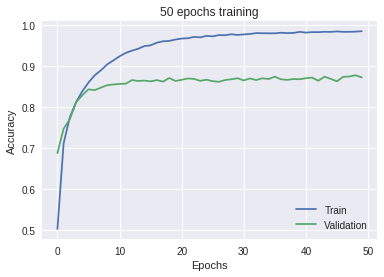

In [29]:
# Plot train/validation accuracy
plt.plot(train_acc_history, label="Train")
plt.plot(val_acc_history, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title("50 epochs training")

In [0]:
def save_model(model, path):
  torch.save(model.state_dict(), path)

In [0]:
save_model(net, os.path.join(path_to_app, "trained_models", "net_50e_087acc.pt"))

In [33]:
# Train model for 5 epochs
net_5 = CNN()
net_5 = net_5.to(device)

optimizer_5 = optim.Adam(net_5.parameters(), lr=0.0001)

net_5, train_hist_5, val_hist_5 = train_model(net_5, dataloaders_dict, criterion, optimizer_5, 5)

Epoch 1/5:

train Loss: 1.2969 | Accuracy: 0.5263

val Loss: 0.8939 | Accuracy: 0.6843

Epoch 2/5:

train Loss: 0.8156 | Accuracy: 0.7170

val Loss: 0.6670 | Accuracy: 0.7705

Epoch 3/5:

train Loss: 0.6396 | Accuracy: 0.7807

val Loss: 0.6146 | Accuracy: 0.7923

Epoch 4/5:

train Loss: 0.5387 | Accuracy: 0.8159

val Loss: 0.5488 | Accuracy: 0.8162

Epoch 5/5:

train Loss: 0.4652 | Accuracy: 0.8412

val Loss: 0.4786 | Accuracy: 0.8391

Training complete in 9m 11s


Text(0.5, 1.0, '5 epochs training')

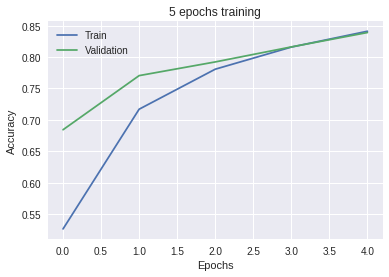

In [34]:
# Plot train/validation accuracy
plt.plot(train_hist_5, label="Train")
plt.plot(val_hist_5, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title("5 epochs training")

In [0]:
save_model(net_5, os.path.join(path_to_app, "trained_models", "net_5e_084acc.pt"))

In [37]:
# Train model for 15 epochs
net_15 = CNN()
net_15 = net_15.to(device)

optimizer_15 = optim.Adam(net_15.parameters(), lr=0.0001)

net_15, train_hist_15, val_hist_15 = train_model(net_15, dataloaders_dict, criterion, optimizer_15, 15)

Epoch 1/15:

train Loss: 1.3477 | Accuracy: 0.5076

val Loss: 0.9126 | Accuracy: 0.6801

Epoch 2/15:

train Loss: 0.8367 | Accuracy: 0.7083

val Loss: 0.7675 | Accuracy: 0.7387

Epoch 3/15:

train Loss: 0.6551 | Accuracy: 0.7761

val Loss: 0.5912 | Accuracy: 0.7996

Epoch 4/15:

train Loss: 0.5469 | Accuracy: 0.8132

val Loss: 0.5308 | Accuracy: 0.8181

Epoch 5/15:

train Loss: 0.4705 | Accuracy: 0.8398

val Loss: 0.4904 | Accuracy: 0.8331

Epoch 6/15:

train Loss: 0.4053 | Accuracy: 0.8635

val Loss: 0.5274 | Accuracy: 0.8296

Epoch 7/15:

train Loss: 0.3588 | Accuracy: 0.8777

val Loss: 0.4588 | Accuracy: 0.8503

Epoch 8/15:

train Loss: 0.3182 | Accuracy: 0.8924

val Loss: 0.5435 | Accuracy: 0.8310

Epoch 9/15:

train Loss: 0.2819 | Accuracy: 0.9039

val Loss: 0.4723 | Accuracy: 0.8544

Epoch 10/15:

train Loss: 0.2478 | Accuracy: 0.9157

val Loss: 0.4802 | Accuracy: 0.8512

Epoch 11/15:

train Loss: 0.2259 | Accuracy: 0.9235

val Loss: 0.4581 | Accuracy: 0.8608

Epoch 12/15:

train

Text(0.5, 1.0, '15 epochs training')

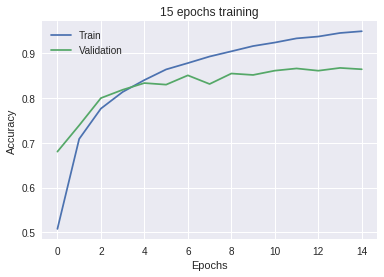

In [38]:
# Plot train/validation accuracy
plt.plot(train_hist_15, label="Train")
plt.plot(val_hist_15, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title("15 epochs training")

In [0]:
save_model(net_15, os.path.join(path_to_app, "trained_models", "net_15e_086acc.pt"))

In [40]:
# Train model for 25 epochs
net_25 = CNN()
net_25 = net_25.to(device)

optimizer_25 = optim.Adam(net_25.parameters(), lr=0.0001)

net_25, train_acc_hist_25, val_acc_hist_25 = train_model(net_25, dataloaders_dict, criterion, optimizer_25, 25)

Epoch 1/25:

train Loss: 1.3345 | Accuracy: 0.5086

val Loss: 0.9100 | Accuracy: 0.6820

Epoch 2/25:

train Loss: 0.8487 | Accuracy: 0.7040

val Loss: 0.7198 | Accuracy: 0.7508

Epoch 3/25:

train Loss: 0.6701 | Accuracy: 0.7703

val Loss: 0.6342 | Accuracy: 0.7878

Epoch 4/25:

train Loss: 0.5605 | Accuracy: 0.8096

val Loss: 0.5730 | Accuracy: 0.8072

Epoch 5/25:

train Loss: 0.4855 | Accuracy: 0.8362

val Loss: 0.5263 | Accuracy: 0.8298

Epoch 6/25:

train Loss: 0.4204 | Accuracy: 0.8567

val Loss: 0.5106 | Accuracy: 0.8293

Epoch 7/25:

train Loss: 0.3676 | Accuracy: 0.8757

val Loss: 0.4864 | Accuracy: 0.8417

Epoch 8/25:

train Loss: 0.3280 | Accuracy: 0.8884

val Loss: 0.4862 | Accuracy: 0.8466

Epoch 9/25:

train Loss: 0.2904 | Accuracy: 0.9006

val Loss: 0.4787 | Accuracy: 0.8484

Epoch 10/25:

train Loss: 0.2591 | Accuracy: 0.9131

val Loss: 0.4454 | Accuracy: 0.8592

Epoch 11/25:

train Loss: 0.2310 | Accuracy: 0.9215

val Loss: 0.4424 | Accuracy: 0.8668

Epoch 12/25:

train

Text(0.5, 1.0, '25 epochs training')

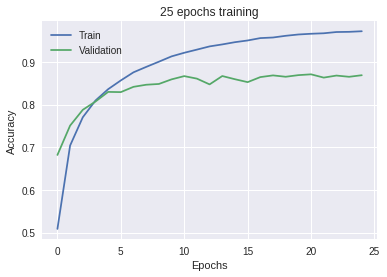

In [41]:
# Plot train/validation accuracy
plt.plot(train_acc_hist_25, label="Train")
plt.plot(val_acc_hist_25, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title("25 epochs training")

In [0]:
save_model(net_25, os.path.join(path_to_app, "trained_models", "net_25e_086acc.pt"))

Text(0.5, 1.0, 'Test accuracy of all models')

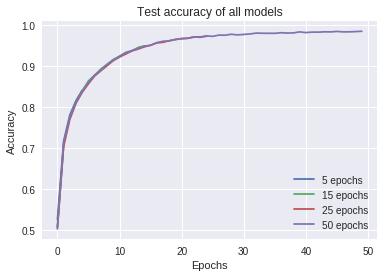

In [44]:
# Plot train scores of all model
plt.plot(train_hist_5, label="5 epochs")
plt.plot(train_hist_15, label="15 epochs")
plt.plot(train_acc_hist_25, label="25 epochs")
plt.plot(train_acc_history, label="50 epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title("Test accuracy of all models")

Text(0.5, 1.0, 'Test accuracy of all models')

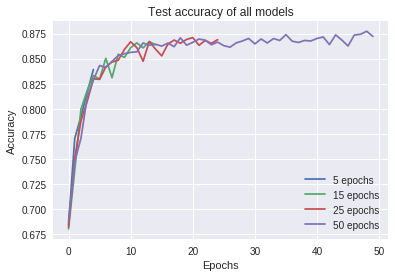

In [43]:
# Plot test scores of all model
plt.plot(val_hist_5, label="5 epochs")
plt.plot(val_hist_15, label="15 epochs")
plt.plot(val_acc_hist_25, label="25 epochs")
plt.plot(val_acc_history, label="50 epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.title("Test accuracy of all models")